In [1]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random

from Combined_Agent_Double.Dueling_DDQN_Agent import Dueling_DDQN_Agent
from Combined_Agent_Double.utils.random_agent import RandomAgent
from Combined_Agent_Double.utils.actions import MORE_ACTIONS
import Combined_Agent_Double.utils.stats_functions as sf

import hockey.hockey_env as h_env

from importlib import reload

In [2]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 + i for i in range(10)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = True

In [5]:
reload(h_env)
env_name = "random_training_3"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)

state_space = env.observation_space

if(USE_MORE_ACTIONS):
    action_space = spaces.Discrete(len(MORE_ACTIONS))
else: 
    action_space = env.discrete_action_space

agent = Dueling_DDQN_Agent(state_space, action_space, seed = seed, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 5)
agent.Q.load(env_name)

#opponent = RandomAgent(seed)
opponent = h_env.BasicOpponent()

stats, losses = sf.load_stats(env_name)

Dueling DQN Network Architecture:
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Dueling DQN Network Architecture:
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Network loaded from random_training_3/weights/training_finished.pth


/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Plot saved at random_training_3/stats/plots/returns_plot.png


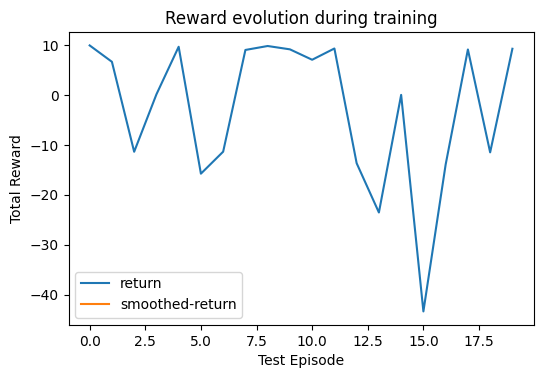

In [6]:
sf.plot_returns(stats, env_name)

Plot saved at random_training_3/stats/plots/losses_plot.png


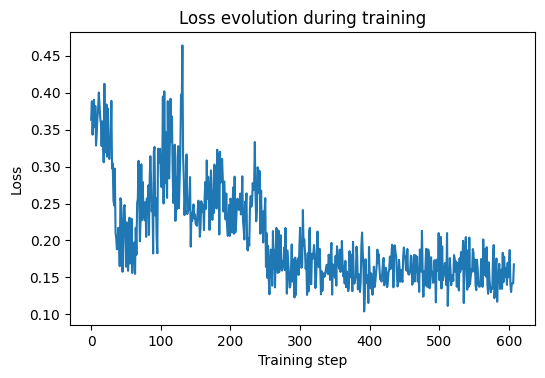

In [7]:
sf.plot_losses(losses, env_name)

Plot saved at random_training_3/stats/plots/beta_evolution.png


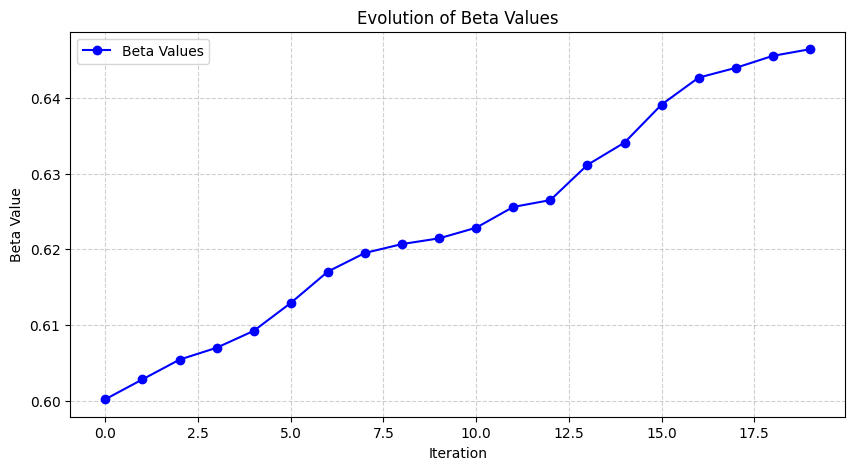

In [8]:
betas = sf.load_betas(env_name)
sf.plot_beta_evolution(env_name, betas)

Plot saved at random_training_3/stats/plots/epsilon_evolution.png


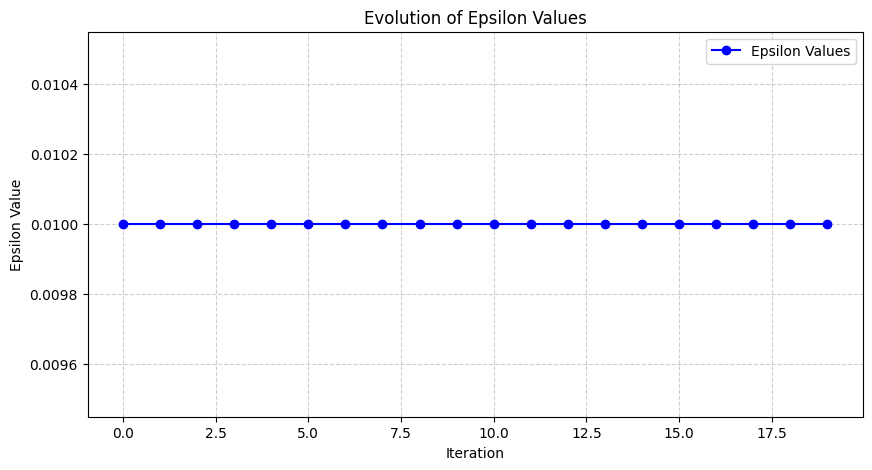

In [9]:
epsilons = sf.load_epsilons(env_name)
sf.plot_epsilon_evolution(env_name, epsilons)

Plot saved at random_training_3/stats/plots/match_evolution.png


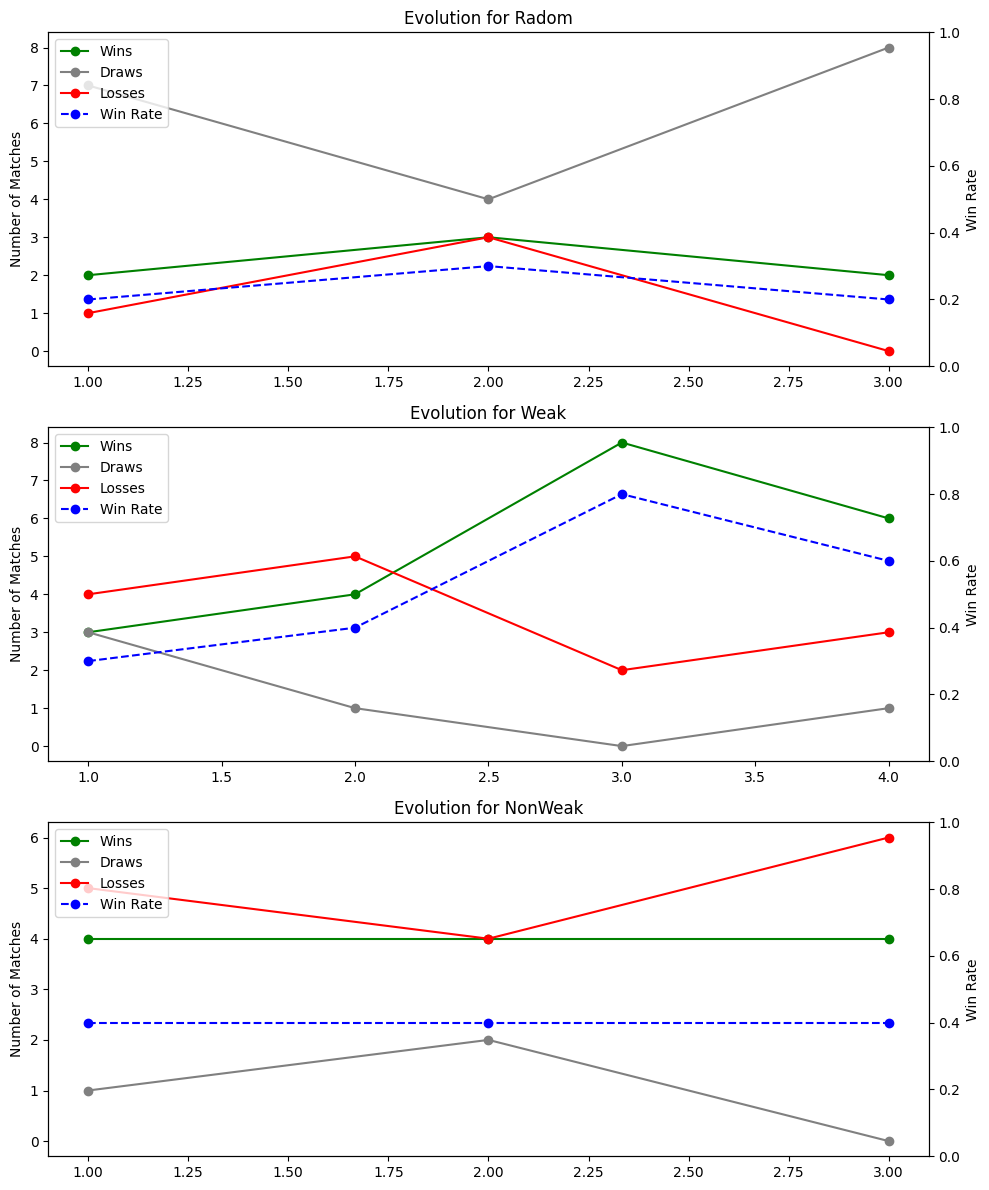

In [11]:
match_history = sf.load_match_history(env_name)
sf.plot_match_evolution_by_chunks(env_name, match_history, ["Radom", "Weak", "NonWeak"], 10)

Test Episode 1, Total Reward: 9.90233667065685
Test Episode 2, Total Reward: -0.3818572923905595
Test Episode 3, Total Reward: 9.855527175180583
Test Episode 4, Total Reward: 9.556969748494302
Test Episode 5, Total Reward: -10.754373038730964
Test Episode 6, Total Reward: 9.562460966610264
Test Episode 7, Total Reward: -10.850954150703977
Test Episode 8, Total Reward: 9.503088348529294
Test Episode 9, Total Reward: 9.644234591634728
Test Episode 10, Total Reward: 9.600963311283573
Plot saved at random_training_1/stats/plots/test_results.png


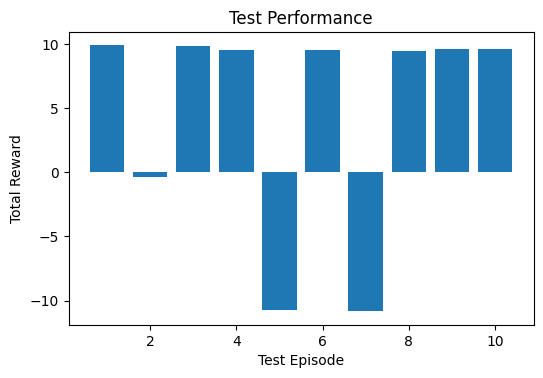

In [8]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards)